# Exercise 3 | TKO_2096 Applications of Data Analysis 2021


## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 10, 20, ..., 200 (that is, 10 meter intervals from 0m to 200m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. Remember to also take advantage of earlier exercises (e.g. C-index). For the 7-nearest neighbor and Euclidean distance calculation you can use third-party libraries (e.g. Scikit-learn) if you want.  


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [2]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import DistanceMetric
from scipy.stats import zscore
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the datasets

In [3]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
#
# Note that the coordinates are in EUREF-TM35FIN format, so you 
# can use the Euclidean distance to calculate the distance between two coordinate points. 

inp = np.loadtxt('input.csv', delimiter=',')
print('Input shape', inp.shape)

output = np.loadtxt('output.csv', delimiter=',')
print('Output shape', output.shape) # NB: output is one-dimensional
coordinates = np.loadtxt('coordinates.csv', delimiter=',')
print('Coordinates shape', coordinates.shape)

Input shape (1691, 75)
Output shape (1691,)
Coordinates shape (1691, 2)


### Standardization of the predictor features (input.csv)

In [4]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this. 
inp_std = zscore(inp, axis=0)

### Functions

In [10]:
# Include here all the functions (for example the C-index-function) that you need in order to implement the task.
def cindex(true_labels, pred_labels):
    """Returns C-index between true labels and predicted labels
    """  
    n = 0
    pairs = 0
    for i in range(len(pred_labels)):
        for j in range(i+1,len(pred_labels)): # start from i+1 to exclude already visited values
            if true_labels[i] != true_labels[j]: # if pairs are comparable (not equal), add to pairs
                pairs += 1
            if (pred_labels[i] < pred_labels[j] and true_labels[i] < true_labels[j]) or (pred_labels[i] > pred_labels[j] and true_labels[i] > true_labels[j]):
                n = n+1
            if pred_labels[i] == pred_labels[j]:
                n = n+0.5
    cindx = n / pairs
    return cindx

def loo(X, y, coord): # leave-one-out CV function
    ds = np.arange(0,201,10) # a list of distances to be tested
    cindx = []
    dist = distance.cdist(coord, coord, metric='euclidean') # calculate a distance from the data points to the rest
    for d in ds:
        true = []
        preds = []
        for i in range(len(X)):
            X_test = X[i].reshape(1, -1) # take the ith sample as a test set
            # include only data points that are further than d from the test point
            # in other words : test the ith row in the distance matrix and use those indexes as a filter
            # note: when d = 0, train set is basically all other points except for the test point
            X_train = X[dist[i] > d]
            y_test = y[i].reshape(1, -1)
            y_train = y[dist[i] > d]
            knn = KNeighborsRegressor(n_neighbors=7, metric='euclidean')
            knn.fit(X_train, y_train)
            pred = knn.predict(X_test)
            preds.extend(pred)
            true.extend(y_test)
        preds = np.array(preds)
        true = np.array(true)
        cindx.append(cindex(true, preds))
    plt.plot(ds,cindx) # plot a "learning curve"
    plt.xlabel('Distance')
    plt.ylabel('C-index')
    plt.show()

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

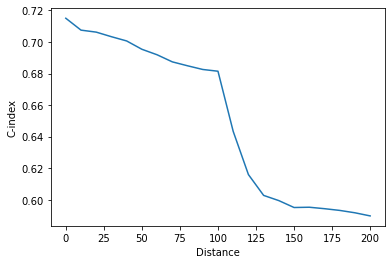

In [11]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

loo(inp_std, output, coordinates)

### Interpretation of the results

#### In this cell, give a brief commentary on the results, what happens to the prediction performance as the prediction distance increases?

The highest c-index values seem to be somewhere between 0.68 and 0.72 (the scale being up to 1.0, this is a nice result IMO). The performance decreases the further we go from the test point. There's a significant drop at performance at 100m distance, which implies that the model isn't reliable when predicting data points that are further than 100m from the training set.